# `fmri-02`: Experimental design

This lab introduces the hemodynamic response function (HRF) and some classical experimental designs. We'll convolve the HRF with a time series of neural activity to model the BOLD response. This lab also walks through some block and event-related design characteristics.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### The hemodynamic response function
First, we'll set some basic experimental parameters. Let's say our experiment (e.g. one scanner run) is 320 seconds (5.3 minutes) long, with a TR of 2 minutes. Recall that the TR describes the sampling rate of our fMRI data; we collect one full volume of brain data per TR.

In [2]:
duration = 320
tr = 2
n_trs = duration // tr

Next, we'll load in a canonical hemodynamic response function (HRF) based on the difference of two gamma functions ([Glover, 1999](https://doi.org/10.1006/nimg.1998.0419)).

In [3]:
from nilearn.glm.first_level import glover_hrf
hrf = glover_hrf(tr, oversampling=1, time_length=30)

Visualize this HRF below using `plt.plot` with an input `x` variable ranging from 0 to 30 seconds at intervals of 2 seconds to match the temporal resolution of the fMRI data. Try adjusting the `oversampling` variable (and `x` variable in the plot) to effectively resample the HRF.

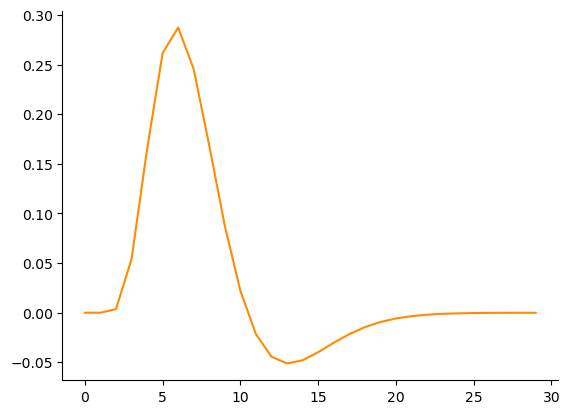

In [4]:
# Plot HRF
hrf = glover_hrf(tr, oversampling=2, time_length=30)
plt.plot(np.arange(0, 30, 1), hrf, c='darkorange')
sns.despine()

Next, we'll create a simple time series of impulses. In the context of an fMRI experiment, these might represent rapidly-occurring neural activity in response to briefly-presented stimuli.

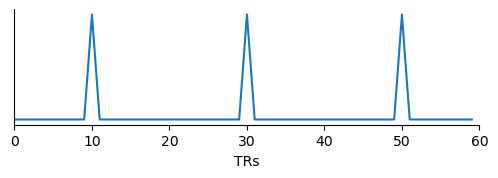

In [5]:
onsets = [10, 30, 50]

impulses = np.zeros(60)
impulses[onsets] = 1

fig, ax = plt.subplots(figsize=(6, 1.5))
ax.plot(impulses, c='tab:blue')
ax.set(xlabel='TRs', xlim=(0, 60), yticks=[])
sns.despine()

Let's visualize how the HRF would transform these impulses. Use `np.convolve` to convolve the above HRF with the impulse time series. (Make sure you reset the HRF to the correct TR are `oversampling` factor to match the impulse time series.) Plot the resulting time series. What does this time series represent?

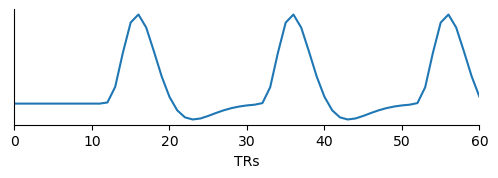

In [6]:
# Convolve impulses with HRF and plot
impulses_bold = np.convolve(impulses, hrf)[:n_trs]
fig, ax = plt.subplots(figsize=(6, 1.5))
ax.plot(impulses_bold)
ax.set(xlabel='TRs', xlim=(0, 60), yticks=[])
sns.despine()

### Block designs
Now, we'll simulate a simple block design with 30-second (15-TR) blocks of alternating stimulus conditions: in this case, faces and houses. Each block is separated by 20 seconds (10 TRs). This design mimics one of the experimental manipulations used to localize face processing in the brain ([Kanwisher et al., 1997](https://doi.org/10.1523/JNEUROSCI.17-11-04302.1997)).

In [7]:
stim_duration = 15
face_onsets = [10, 60, 110]
house_onsets = [35, 85, 135]

In [8]:
face_blocks = np.zeros(n_trs)
for onset in face_onsets:
    face_blocks[onset:onset + stim_duration] = 1

house_blocks = np.zeros(n_trs)
for onset in house_onsets:
    house_blocks[onset:onset + stim_duration] = 1

Plot these two "boxcar" time series below. These time series represent the hypothesized neural activitiy associated with the perception of faces and the perception of houses. In subsequent labs, we'll use statistical methods to compare (i.e. subtract or "contrast") responses to these two types of stimuli.

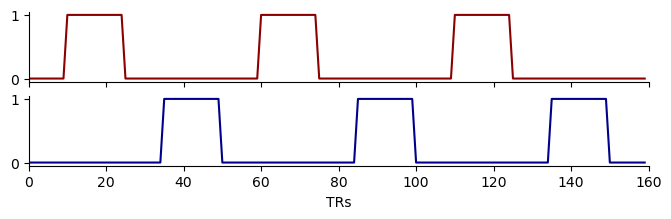

In [9]:
# Plot boxcar time series
fig, axs = plt.subplots(2, 1, figsize=(8, 2),
                        sharex=True, sharey=True)
axs[0].plot(face_blocks, c='darkred')
axs[1].plot(house_blocks, c='darkblue')
axs[1].set(xlabel='TRs', xlim=(0, 160))
sns.despine()

Next, to better capture the BOLD response, convolve these boxcar time series with the HRF. Plot the resulting time series below. Note how, for the most part, the BOLD response returns to baseline prior to the presentation of a subsequent block.

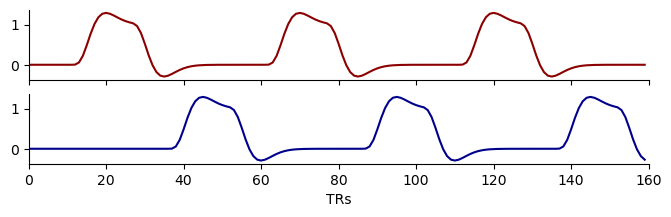

In [10]:
# Convolve boxcars with HRF and plot
face_blocks = np.convolve(face_blocks, hrf)[:n_trs]
house_blocks = np.convolve(house_blocks, hrf)[:n_trs]

fig, axs = plt.subplots(2, 1, figsize=(8, 2),
                        sharex=True, sharey=True)
axs[0].plot(face_blocks, c='darkred')
axs[1].plot(house_blocks, c='darkblue')
axs[1].set(xlabel='TRs', xlim=(0, 160))
sns.despine()

Finally, you will often see these time series represented as columns in a "design matrix". Use `np.column_stack` to combine these time series as columns—alongside an additional column of ones (i.e. the intercept)—into a matrix `X`. Plot the matrix below.

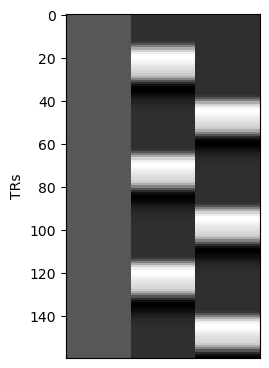

In [11]:
# Create design matrix and plot
X = np.column_stack((np.ones(n_trs) / 4,
                     face_blocks,
                     house_blocks))

fig, ax = plt.subplots(figsize=(2.5, 5))
ax.matshow(np.repeat(X, 30, axis=1), cmap='binary_r')
ax.set(xticks=[], ylabel='TRs');

### Event-related designs
In this exercise, we'll simulate a simple event-design with brief stimulus presentations, short interstimulus intervals (ISIs), resulting in overlapping BOLD responses. We'll pack 40 events into our 320-second long experimental run: 20 face events and 20 house events. Each event is one TR in duration. To jitter the onsets of our events, we'll sample ISIs from a geometric distribution. Here, we jitter by one or more TRs, but most fMRI software also allows you to jitter event onsets on the scale of milliseconds. After generating our 40 total jittered event onsets, we randomly assign 20 to the face condition and 20 to the house condition. Note that there are dedicated software tools for generating more sophisticated, more efficient event-related designs (e.g. FreeSurfer's [Optseq](https://surfer.nmr.mgh.harvard.edu/optseq/), AFNI's [@stim_analyze](https://afni.nimh.nih.gov/pub/dist/edu/data/CD.expanded/AFNI_data6/ht03/@stim_analyze); [Dale, 1999](https://doi.org/10.1002/(SICI)1097-0193(1999)8:2/3%3C109::AID-HBM7%3E3.0.CO;2-W)).

In [12]:
np.random.seed(420)

n_events = 40
onsets = np.cumsum(tr + np.random.geometric(.5, n_events))
face_ids = np.sort(np.random.choice(np.arange(n_events), size=n_events // 2, replace=False))
house_ids = np.array([i for i in np.arange(n_events) if i not in face_ids])
face_onsets = onsets[face_ids]
house_onsets = onsets[house_ids]

In [13]:
face_events = np.zeros(n_trs)
face_events[face_onsets] = 1

house_events = np.zeros(n_trs)
house_events[house_onsets] = 1

Plot the two time series for face and house events below. These time series represent the hypothesized neural events occurring rapidly in response to the brief presentation of face and house stimuli.

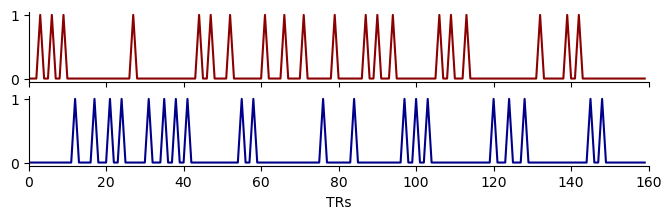

In [14]:
# Plot the event time series
fig, axs = plt.subplots(2, 1, figsize=(8, 2),
                        sharex=True, sharey=True)
axs[0].plot(face_events, c='darkred')
axs[1].plot(house_events, c='darkblue')
axs[1].set(xlabel='TRs', xlim=(0, 160))
sns.despine()

Next, convolve the face and house event time series with the HRF to generate the predicted BOLD responses for the two types of stimuli. Plot the resulting time series. Note that the BOLD responses to adjacent stimuli are highly overlapping and do not return to baseline between events.

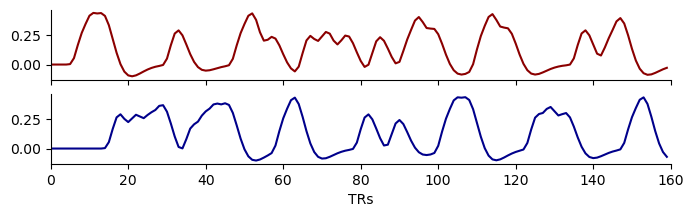

In [15]:
# Convolve event time series with HRF and plot
face_events = np.convolve(face_events, hrf)[:n_trs]
house_events = np.convolve(house_events, hrf)[:n_trs]

fig, axs = plt.subplots(2, 1, figsize=(8, 2),
                        sharex=True, sharey=True)
axs[0].plot(face_events, c='darkred')
axs[1].plot(house_events, c='darkblue')
axs[1].set(xlabel='TRs', xlim=(0, 160))
sns.despine()

Now, similarly to the block design, stack these two regressors (along with a constant vector of ones) into a design matrix `X`. Plot the design matrix below.

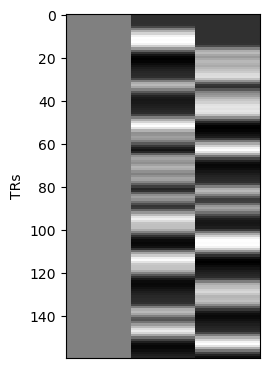

In [16]:
# Plot the design matrix
X = np.column_stack((np.ones(n_trs) / 6,
                     face_events,
                     house_events))

fig, ax = plt.subplots(figsize=(2.5, 5))
ax.matshow(np.repeat(X, 30, axis=1), cmap='binary_r')
ax.set(xticks=[], ylabel='TRs');

Try recombining the original face and house event time series (prior to convolving with the HRF) into a single time series. Then, convolve this time series of all events with the HRF. Plot the resulting time series.

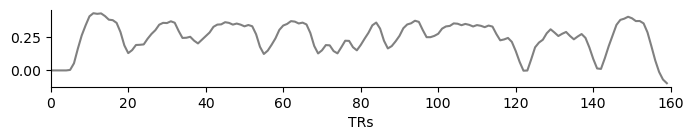

In [17]:
# Combine face and house events, convolve with HRF, and plot
face_events = np.zeros(n_trs)
face_events[face_onsets] = 1

house_events = np.zeros(n_trs)
house_events[house_onsets] = 1

all_events = face_events + house_events
all_events = np.convolve(all_events, hrf)[:n_trs]

fig, ax = plt.subplots(1, 1, figsize=(8, 1),
                       sharex=True, sharey=True)
ax.plot(all_events, c='gray')
ax.set(xlabel='TRs', xlim=(0, 160))
sns.despine()

#### References

* Dale, A. M. (1999). Optimal experimental design for event‐related fMRI. _Human Brain Mapping_, _8_(2‐3), 109–114. https://doi.org/10.1002/(SICI)1097-0193(1999)8:2/3%3C109::AID-HBM7%3E3.0.CO;2-W

* Glover, G. H. (1999). Deconvolution of impulse response in event-related BOLD fMRI. _NeuroImage_, _9_(4), 416–429. https://doi.org/10.1006/nimg.1998.0419

* Kanwisher, N., McDermott, J., & Chun, M. M. (1997). The fusiform face area: a module in human extrastriate cortex specialized for face perception. _Journal of Neuroscience_, _17_(11), 4302–4311. https://doi.org/10.1523/JNEUROSCI.17-11-04302.1997